We are going to create a resample procedure, that will be able to work with irregular data coming from wireless devices. As it was said previously, the proper resampling/restoring of the data is essential, particularly for ML algorithms, that will be used in the future.
We will call the array of raw data coming from devices <code>[[timestamp1, timestamp2, ...], [value1, value2, ...]]</code> a "datastream".
The data after cleaning, validation and processing with the help of our resampling procedure will be stored in some structure similar to a datastream, but called a "datafeed".

The monitoring applications will then take these "datafeeds" and make inferences or provide us with insights based on this "brushed" data.

Each datastream has a couple of parameters that reflect the properties of the process being monitored. In this text, they will be called <b>T_const</b> and <b>T_change</b>. <b>T_const</b> shows the period during which it is possible to assume that the value of the magnitude doesn't change. For example, for an external temperature sensor, this value can be of several seconds, while for the flowrate of liquid that changes quite quickly, it will hardly be even a couple of seconds. <b>T_change</b> is responsible for showing the maximum duration between two measurements during which the magnitude could only monotonously rise or decrease. Say. you have two temperature readings taken with an interval of 1 minute, one is 30C and the second is 35C. Common sense tells us that it can be assumed with a high degree of probability that during this minute the temperature gradually approached the final value without oscillations (so, the first derivative was positive along the whole way from point A to point B). If this interval were, for example, 5 minutes, then it would be difficult to assume that this way was covered monotonously. Both these values are determined by engineers, who have sufficient information about the process. 

First, we simply place the points from a datastream on the coordinate plane (time, value), and then apply a so-called "grid" on it. The <b>grid</b> can be thought of set of equidistant vertical lines, and the distance between these lines is ... We will call it "minimal resampling time" and it will be the minimum from all <b>T_const</b> of all datastreams involved in the application. Let's call it <b>T_const_min</b>. Then we will build the spline passing all the points, or better to say, the groups of points. Then we take the points where this spline intersects with our grid and voila - we have equidistantly distributed points which thanks to the spline represent with a certain degree of reliability the initial shape of the continuous signal. We will call this set of points a "datafeed", which is opposite to a "datastream".

<img src="./images/t1/1.1.jpg" style="width: 500px;"/><br>Fig.1.1<br><br>

Pay attention that the timestamps of the grid lines don't start their count from the timestamp of the first point of raw data (the leftmost blue in Fig.1.1) - this approach is used quite often as the default behavior in resampling libraries - but from the closest from the left "rounded" timestamp. Thus, in Fig. 1.2 we start from the timestamp 8:21:00 with the resampling time of 20 sec. To implement this we will need some special functions, which we'll introduce later.

About building a spline that goes through the group of raw data points. As we are going to use piecewise splines, the line between two adjacent points can only go in one direction - up or down.

https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html

That is why we need <b>T_change</b> - if the distance between two points is bigger than <b>T_change</b>, we don't connect them with a spline. In the ideal world, we should have a transmitter that ensures data transmission at intervals at least < <b>T_change</b> (it would be absolutely fantastic if this transmission rate were <b>T_const</b>, but < <b>T_change</b> is also not bad), but in real life there are always interruptions, glitches and other things that make the thing more difficult to deal with. 

All these theoretical moments are described better in the Word document. Here we a trying to explain why one resampling algorithm was chosen from many different options.

For the sake of simplicity, we will use "vanilla" Python lists, datetime.datetime and datetime.timedelta objects to illustrate the main points. The results will be reflected in the graphs built by the matplotlib library.

In [1]:
from datetime import datetime, timedelta, timezone
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


First of all, let's define a couple of functions that we will need in our future calculations. We will need a functionality for "rounding" timestamps, so here are functions that provide it. One remark: all the variables responsible for time intervals are in seconds (even though it is not expressed explicitly in their names). This agreement will be used further in the text.

In [2]:
def floorDatetime(dt, interval):
    rounded_seconds = (dt.second // interval) * interval
    return dt.replace(second=rounded_seconds, microsecond=0)

def ceilDatetime(dt, interval):
    rounded_seconds = (dt.second // interval + 1) * interval
    return dt.replace(second=0, microsecond=0) + timedelta(seconds=rounded_seconds)

Now we need a function to build a grid around a set of datastream points. Let me remind us that a "grid" is a set of vertical lines tied to some "round" timestamps. If we are going to sample all the datastreams from our application with the frequency of, say, 20 seconds, these lines will have x-coordinates similar to 13:26:00, 13:26:20, 13:26:40 etc. As we will see later, this approach has some disadvantages, but due to its simplicity (and the fact that T_const_min usually shouldn't be large), it will work. The function should create a set of "round" timestamps that surround the "raw" timestamps from both sides. What happens here? We expect an array with datetime objects sorted in ascending order. This array should have at least two elements (that's why we check the length of the array first). Then we "floor" the first timestamp and "ceil" the last one, the difference between them divided by the interval (out T_const_min) will give us the number of integer intervals between these timestamps. The number of lines will be 1 more than the number of intervals.

The variable <code>epsilon</code> is introduced just in case of rounding float numbers. <code>td.total_seconds()/interval</code> gives us a float value, which should be very close to the same integer, but sometimes it can be something like 7.99999999 not 8.0000000. By adding the <code>epsilon</code> we avoid this problem. It is not the real "system epsilon", which is much smaller, but small enough. As we are going mostly to work with seconds (tens/hundreds of seconds) and not their fractions, it should be OK.

In [3]:
epsilon = 0.0000000001

class LogLevel:
    INFO = 'INFO'
    WARNING = 'WARN'
    ERROR = 'ERROR'

def log(text, level):
    # for now let's keep it simple
    print(f'[{level}]: {text}')

def create_ts_grid(dt_arr, interval):
    if len(dt_arr) == 0:
        log('create_ts_grid: Input data is invalid', LogLevel.ERROR)
        return
    td = ceilDatetime(dt_arr[-1], interval) - floorDatetime(dt_arr[0], interval)
    k = int(td.total_seconds()/interval+epsilon) + 1 
    grid = [(floorDatetime(dt_arr[0], interval)+timedelta(seconds=step*interval)).timestamp() 
            for step 
            in range(0, k)]
    return grid

Let's check it with some examples. We will start with a datastream that contains only two readings. The readings will be stored in <code>val_arr</code>, and the initial timestamps will be kept in <code>dt_arr</code> ("dt" means datetime).  
The difference between these raw timestamps is a bit less than 40 seconds. We will try to see what grids our function will create if we use "interval" values: bigger than 40s, smaller than 40s and significantly smaller than 40s.

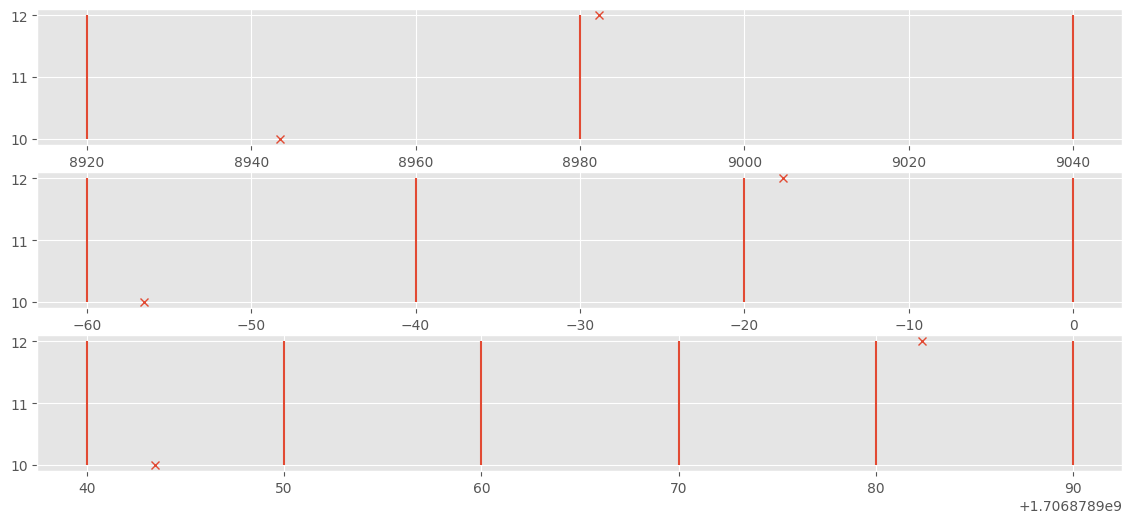

In [4]:
val_arr = [10, 12]
dt_arr = [datetime.fromisoformat("2024-02-02T13:02:23.457Z"), 
        datetime.fromisoformat("2024-02-02T13:03:02.327Z")]
ts_arr = [x.timestamp() for x in dt_arr]
ts_grid_arr = [create_ts_grid(dt_arr, 60), create_ts_grid(dt_arr, 20), create_ts_grid(dt_arr, 10)]
fig, ax = plt.subplots(3, 1, figsize=(14, 6))
y_min = min(val_arr)
y_max = max(val_arr)
for a, ts_grid in zip(ax, ts_grid_arr):
    a.plot(ts_arr, val_arr, 'x')
    if ts_grid_arr:
        a.vlines(ts_grid, y_min , y_max)


In the next example let's see how it performs when one of the timestamps is already "round". It is unlikely to have such a "round" timestamp in real life, but our function should work correctly with any values. Looks like it works properly.

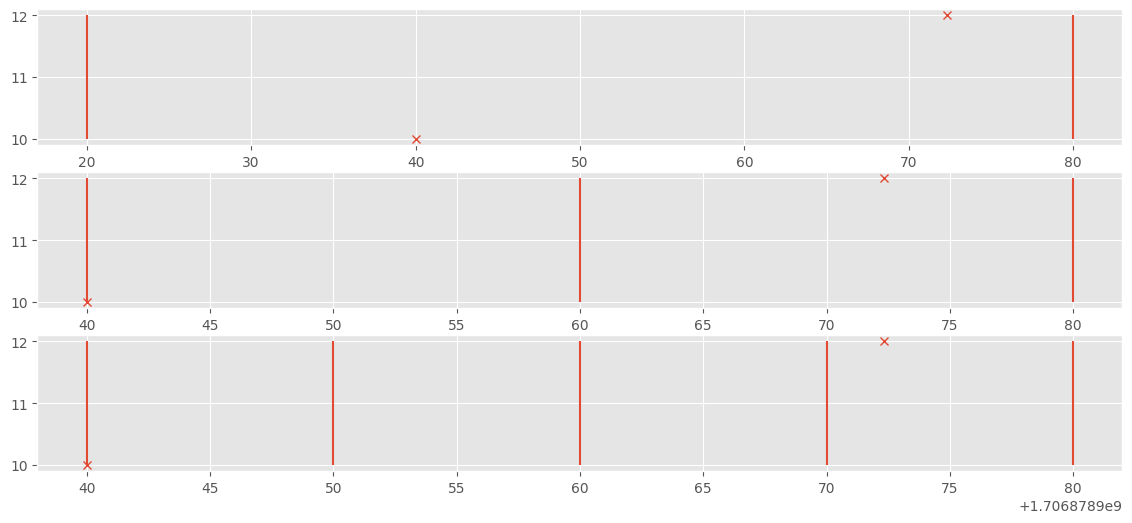

In [5]:
val_arr = [10, 12]
dt_arr = [datetime.fromisoformat("2024-02-02T13:02:20.000Z"), 
          datetime.fromisoformat("2024-02-02T13:02:52.327Z")]
ts_arr = [x.timestamp() for x in dt_arr]
ts_grid_arr = [create_ts_grid(dt_arr, 60), create_ts_grid(dt_arr, 20), create_ts_grid(dt_arr, 10)]

fig, ax = plt.subplots(3, 1, figsize=(14, 6))

y_min = min(val_arr)
y_max = max(val_arr)

for a, ts_grid in zip(ax, ts_grid_arr):
    a.plot(ts_arr, val_arr, 'x')
    if ts_grid_arr:
        a.vlines(ts_grid, y_min , y_max)

Let's add more points on the canvas.

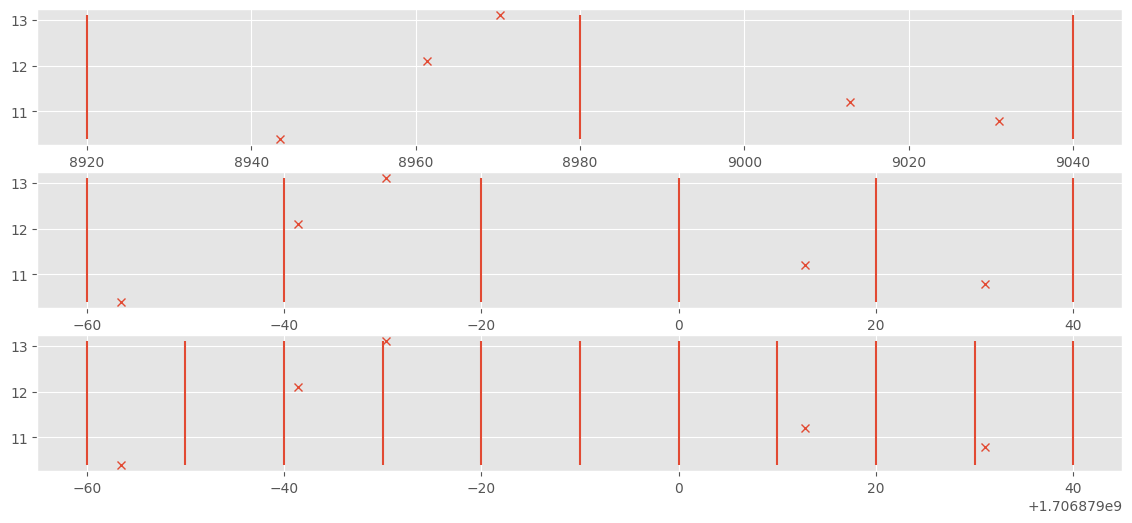

In [6]:
val_arr = [10.4, 12.1, 13.1, 11.2, 10.8]
dt_arr = [datetime.fromisoformat("2024-02-02T13:02:23.457Z"), 
          datetime.fromisoformat("2024-02-02T13:02:41.419Z"),
          datetime.fromisoformat("2024-02-02T13:02:50.321Z"),
          datetime.fromisoformat("2024-02-02T13:03:32.802Z"),
          datetime.fromisoformat("2024-02-02T13:03:51.039Z")]
ts_arr = [x.timestamp() for x in dt_arr]
ts_grid_arr = [create_ts_grid(dt_arr, 60), create_ts_grid(dt_arr, 20), create_ts_grid(dt_arr, 10)]

fig, ax = plt.subplots(3, 1, figsize=(14, 6))

y_min = min(val_arr)
y_max = max(val_arr)

for a, ts_grid in zip(ax, ts_grid_arr):
    a.plot(ts_arr, val_arr, 'x')
    if ts_grid_arr:
        a.vlines(ts_grid, y_min , y_max)

As can be seen from the last graph, in certain cases, more than one reading gets into an "interval bin". In real applications, it may happen when data comes more frequently than we counted on. It is not bad, but it poses a certain contradiction. As we agreed, the interval value represents <b>T_const_min</b>, which means that during this period the magnitude has a constant value. If we decided that <b>T_const</b> for this datafeed had a certain value, then we probably had some grounds for it. So, there can be only a single value for each "interval bin". Another inconvenience of having too many values is that it can be quite difficult for the spline engine to draw a spline when the points are lying too close to each other, and especially difficult when there are some outliers in the dataset (Fig.1.2).

<img src="./images/t1/1.2.jpg" style="width: 500px;"/>

The solution here could be to find a spline engine that doesn't drag the spline exactly through the initial points but can draw it in a "smoothed" way (like in Fig.1.3). This looks good but can make things quite complicated.

<img src="./images/t1/1.3.jpg" style="width: 500px;"/>

How about filtering the values first and then just finding their average? We could use the median filter, but it requires at least 3 points, which is not something that we will have at our disposal. 

For filtering we can introduce such a parameter for each datastream as the max rate of change (for instance, 0.5C/s for a certain temperature measurement point) and by using it we can pull down/pull up the values-outliers (like in Fig. 1.4).

<img src="./images/t1/1.4.jpg" style="width: 500px;"/>

Then we can just average both timestamps and values for all points from the same bin, thus squashing them into one point. The function whose code is listed below provides us with this functionality.

In [7]:
def limit_values_by_roc(dt_arr, val_arr, roc, base_point = None): # roc is in unit/s, base_point -> [dt, value]
    if len(dt_arr) != len(val_arr) or (len(dt_arr) == 1 and not base_point) or len(dt_arr) == 0 or roc <= 0:
        log('limit_values_by_roc: Input data is invalid', LogLevel.ERROR)
        return
    filtered_val_arr = val_arr.copy() # shallow copy should be enough here

    if base_point:
        sign = 1
        if filtered_val_arr[0] - base_point[1] < 0:
            sign = -1
        limited_next_val = base_point[1] + sign * roc * (dt_arr[0] - base_point[0]).total_seconds()
        if (sign > 0 and limited_next_val < filtered_val_arr[0]) or \
           (sign < 0 and limited_next_val > filtered_val_arr[0]):
            filtered_val_arr[0] = limited_next_val

    for i in range(len(dt_arr)-1):
        sign = 1
        if filtered_val_arr[i+1] - filtered_val_arr[i] < 0:
            sign = -1
        limited_next_val = filtered_val_arr[i] + sign * roc * (dt_arr[i+1] - dt_arr[i]).total_seconds()
        if (sign > 0 and limited_next_val < filtered_val_arr[i+1]) or \
           (sign < 0 and limited_next_val > filtered_val_arr[i+1]):
            filtered_val_arr[i+1] = limited_next_val
    return filtered_val_arr

As can be seen, we gradually go from point to point, comparing its value with the previous value. In our version, if the value for point "k-1" was pulled, it is used as a point of reference for point "k" (not the original value of point "k-1", which is sitting in the original "val_arr"). That is why "filtered_val_arr" is used in the cycle. Also, it should be noted that an additional point outside the range of the <code>val_arr</code> is introduced as an optional parameter <code>base_point</code> to ensure that the first value of <code>val_arr</code> also has chances to be pulled. This option will come in handy when we try to build a piecewise spline (described in the next chapter). 

Now let's test our function with some data.

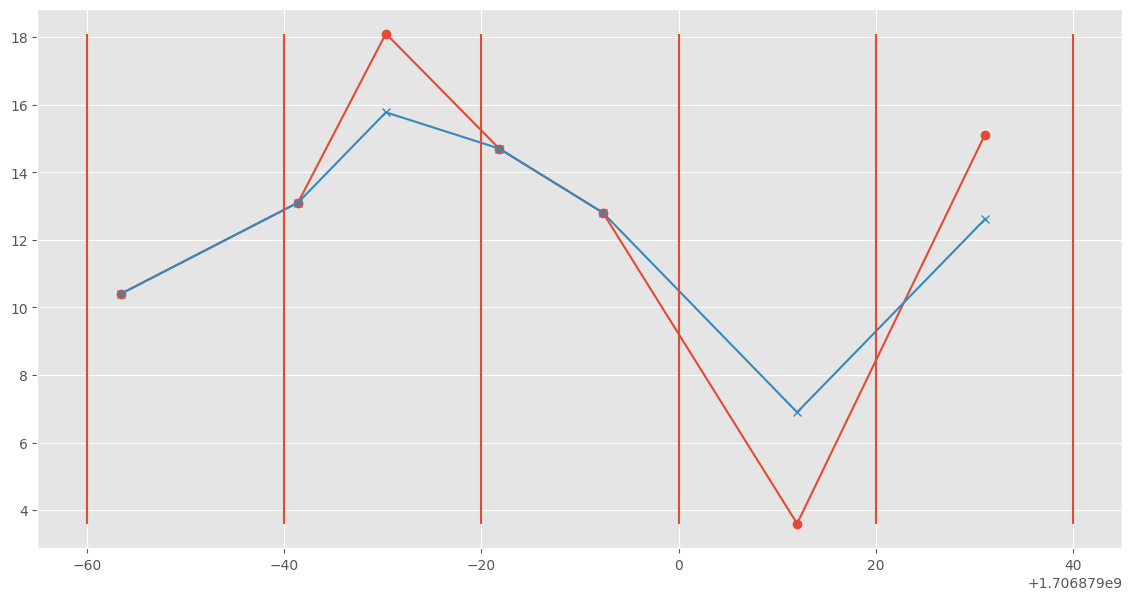

In [8]:
val_arr = [10.4, 13.1, 18.1, 14.7, 12.8, 3.6, 15.1]
dt_arr = [datetime.fromisoformat("2024-02-02T13:02:23.457Z"), 
          datetime.fromisoformat("2024-02-02T13:02:41.419Z"),
          datetime.fromisoformat("2024-02-02T13:02:50.321Z"),
          datetime.fromisoformat("2024-02-02T13:03:01.802Z"),
          datetime.fromisoformat("2024-02-02T13:03:12.328Z"),
          datetime.fromisoformat("2024-02-02T13:03:32.014Z"),
          datetime.fromisoformat("2024-02-02T13:03:51.039Z")]
ts_arr = [x.timestamp() for x in dt_arr]
ts_grid = create_ts_grid(dt_arr, 20)

roc = 0.3

filtered_val_arr = limit_values_by_roc(dt_arr, val_arr, roc)

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

y_min = min(val_arr)
y_max = max(val_arr)


ax.plot(ts_arr, val_arr, 'o-')
ax.plot(ts_arr, filtered_val_arr, 'x-')
ax.vlines(ts_grid, y_min , y_max)

Now let's do the second part - squash all the points placed in a single "interval bin". As we have N intervals and N+1 points forming these intervals, we will use left-closed intervals, which means that for the dt interval [a, b) we can include the point with the timestamp "a", but the point with the timestamp "b" will go to the next interval. That is why we have ">=" but only "<" in this line of the code:

<code>dt_arr[idx_dt] >= dt_grid[idx_grid-1] and dt_arr[idx_dt] < dt_grid[idx_grid]</code>

In [9]:
def squash_bins(dt_arr, val_arr, dt_grid): # dt_arr, val_arr, grid must be sorted in ascending order, grid[0] <= dt_arr[0], grid[-1] >= dt_arr[-1]
    if len(dt_arr) != len(val_arr) or len(dt_grid) < 2:
        log('squash_bins: Input data is invalid', LogLevel.ERROR)
        return None, None
    
    aver_val_arr = []
    aver_dt_arr = []
    sq_dt_arr = []
    sq_val_arr = []
    idx_dt = 0

    for idx_grid in range(1, len(dt_grid)):
        while idx_dt <= len(dt_arr): 
        # the trick with idx_dt <= len(dt_arr) is necessary to be able to go to the 'else' branch after the last element of dt_arr has been processed
            if idx_dt < len(dt_arr) and dt_arr[idx_dt] >= dt_grid[idx_grid-1] and dt_arr[idx_dt] < dt_grid[idx_grid]:
                aver_dt_arr.append(dt_arr[idx_dt].timestamp()) # timestamp to beable to make the '+' operation later
                aver_val_arr.append(val_arr[idx_dt])
                idx_dt += 1
            else:
                if(len(aver_dt_arr)>0):
                    sq_dt_arr.append( datetime.fromtimestamp(sum(aver_dt_arr)/len(aver_dt_arr), tz=timezone.utc) )
                    sq_val_arr.append( sum(aver_val_arr)/len(aver_val_arr) )
                    aver_dt_arr = []
                    aver_val_arr = []
                break
    return sq_dt_arr, sq_val_arr


If we apply this function on the previously obtained <code>filtered_val_arr</code> we will get such a "squashed" set of points.

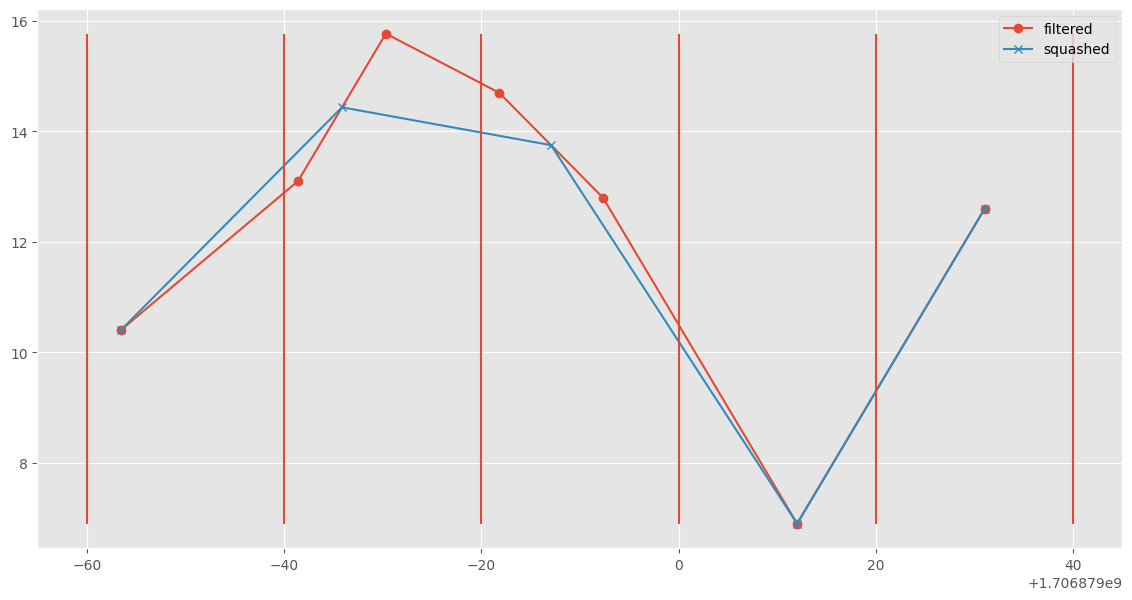

In [10]:
dt_grid = [datetime.fromtimestamp(x, tz=timezone.utc) for x in ts_grid]

sq_dt_arr, sq_val_arr = squash_bins(dt_arr, filtered_val_arr, dt_grid)

sq_ts_arr = [x.timestamp() for x in sq_dt_arr]

# for dt, val in zip(sq_dt_arr, sq_val_arr):
#     print(f'{dt.isoformat()} -> {val:.2f}')

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

y_min = min(filtered_val_arr)
y_max = max(filtered_val_arr)


ax.plot(ts_arr, filtered_val_arr, 'o-', label='filtered')
ax.plot(sq_ts_arr, sq_val_arr, 'x-', label='squashed')
ax.vlines(ts_grid, y_min , y_max)

plt.legend()

And now let's try to build a spline over the points. For now, we will use a PCHIP interpolator (we will speak about it later). As we have only five points and a relatively large zoom, the resulting line doesn't resemble a spline a lot (it is not smooth). We will see later when we use the datasets with a bigger number of samples how it works.

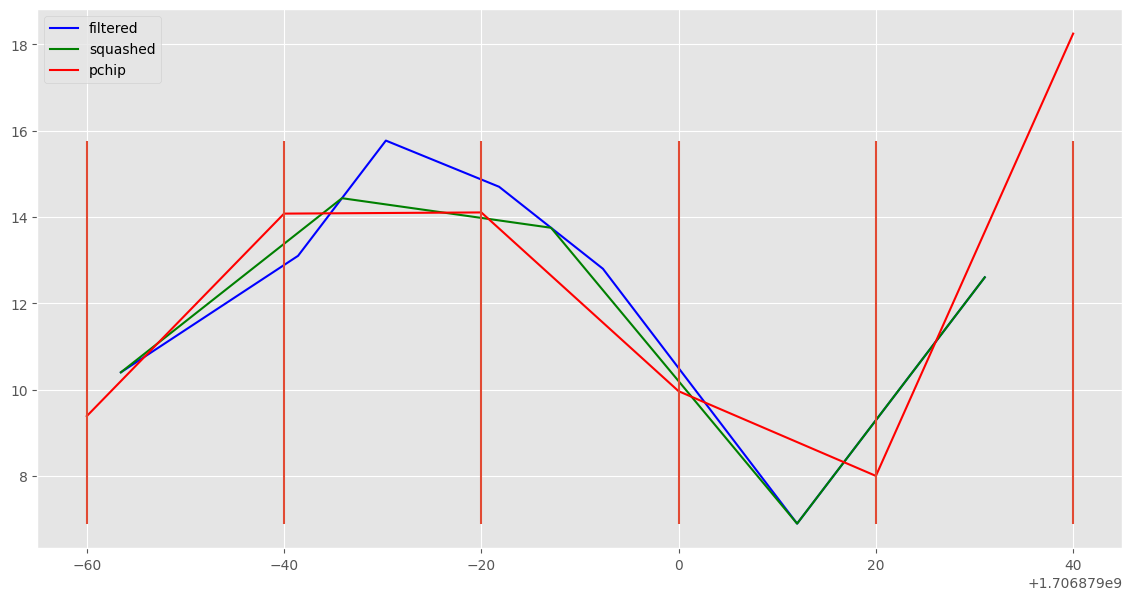

In [11]:
from scipy.interpolate import PchipInterpolator

pchip = PchipInterpolator(sq_ts_arr, sq_val_arr)(ts_grid)

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

ax.plot(ts_arr, filtered_val_arr, '-b', label='filtered')
ax.plot(sq_ts_arr, sq_val_arr, '-g', label='squashed')
ax.plot(ts_grid, pchip, '-r', label='pchip')
ax.vlines(ts_grid, y_min , y_max)

plt.legend()

Or, just for demonstration reasons, we can go with a smaller interval of our grid, so you can see the shape of the spline better (the red line). As can be seen, it touches the knots of our "filtered/squashed" datastream (the green line and green crosses). The initial data is represented in violet dots.

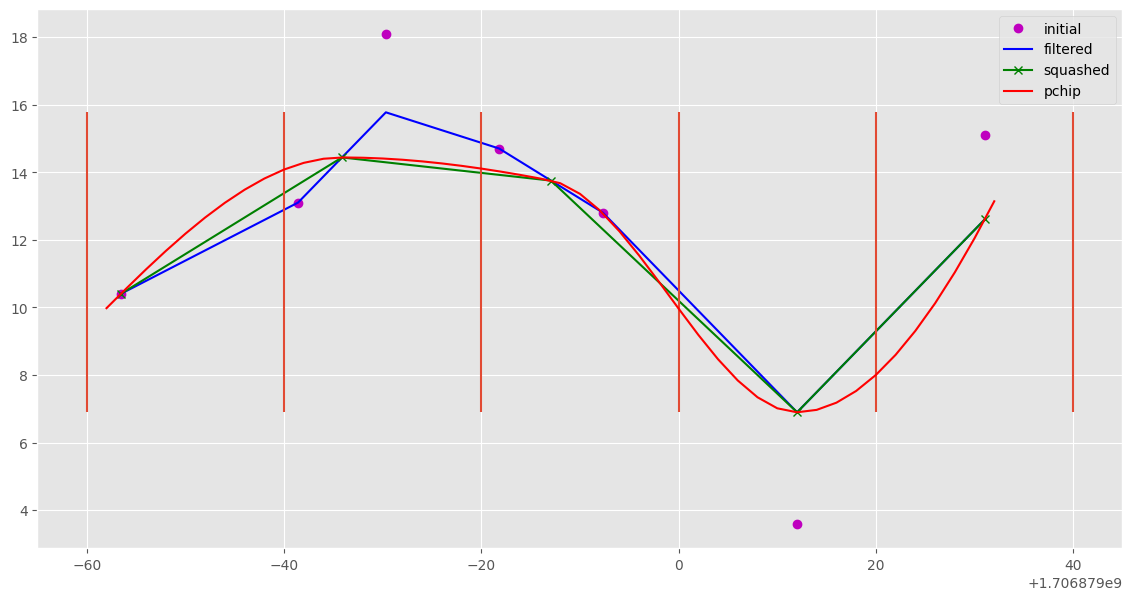

In [12]:


fig, ax = plt.subplots(1, 1, figsize=(14, 7))

ax.plot(ts_arr, val_arr, 'om', label='initial')
ax.plot(ts_arr, filtered_val_arr, '-b', label='filtered')
ax.plot(sq_ts_arr, sq_val_arr, 'x-g', label='squashed')

ax.vlines(ts_grid, y_min , y_max)
ts_grid = create_ts_grid(dt_arr, 2)
pchip = PchipInterpolator(sq_ts_arr, sq_val_arr)(ts_grid)

ax.plot(ts_grid, pchip, '-r', label='pchip')


plt.legend()

One more question at the end of the chapter: would it be more correct to squash first and then apply the "ROC" filter?

In [13]:
# from mockdata import dt_mock_1, val_mock_1
# dt_test_arr = dt_mock_1[47:62]
# val_test_arr = val_mock_1[47:62]

# ts_test_grid = create_ts_grid(dt_test_arr, interval=20)

# filtered_test_val_arr = limit_values_by_roc(dt_test_arr, val_test_arr, roc, None)

# dt_test_grid = [datetime.fromtimestamp(x, tz=timezone.utc) for x in ts_test_grid]
# sq_dt_arr, sq_val_arr = squash_bins(dt_test_arr, filtered_test_val_arr, dt_test_grid)

# for dt, val in zip(sq_dt_arr, sq_val_arr):
#     print(f'{dt.isoformat()} -> {val}')